In [1]:
import wave
import sys
import IPython.display as ipd
import numpy as np
import matplotlib.pyplot as plt
from  scipy import signal

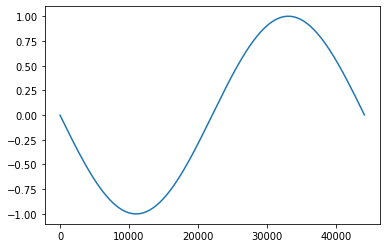

In [4]:
x = np.linspace(-3.14,3.14,44100)
sine = np.sin(x)
plt.plot(sine)
plt.show()

In [5]:
def getAudio(fileName):
    file = wave.open(fileName)
    samples = file.getnframes()
    sr = file.getframerate()
    audio = file.readframes(samples)
    audio_16 = np.frombuffer(audio,dtype=np.int16)
    audio_32 = audio_16.astype(np.float32)
    max_int16 = 2**14
    audio_normalised = audio_32 / max_int16
    return audio_normalised,sr

In [6]:
input1,sr1 = getAudio('input1.wav')
input2,sr2 = getAudio('input2.wav')
input3,sr3 = getAudio('input3.wav')

In [7]:
def fuzz(inputAudio,fuzz=1,treshold=0.15):
    audio = np.copy(inputAudio)
    for sample in np.nditer(audio, op_flags = ['readwrite']):
        if sample > treshold:
            sample[...] = fuzz
        elif sample < -treshold:
            sample[...] = -fuzz
    return audio


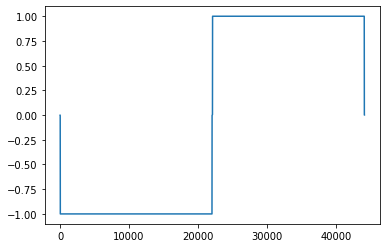

In [49]:
fuzzSine = fuzz(sine,treshold=0.005)
plt.plot(fuzzSine)
plt.show()

In [9]:
ipd.Audio(input1,rate=sr1)

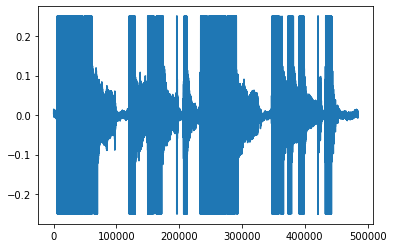

In [10]:
fuzzOut = fuzz(input1,0.25,treshold=0.125)
plt.plot(fuzzOut)
plt.show()
ipd.Audio(fuzzOut,rate=sr1)

In [55]:
def highpass_filter(y, sr):
    filter_stop_freq = 73  # Hz
    filter_pass_freq = 140 # Hz
    filter_order = 1001

    # High-pass filter
    nyquist_rate = sr / 2.
    desired = (0, 0, 1, 1)
    bands = (0, filter_stop_freq, filter_pass_freq, nyquist_rate)
    filter_coefs = signal.firls(filter_order, bands, desired, nyq=nyquist_rate)

    # Apply high-pass filter
    filtered_audio = signal.filtfilt(filter_coefs, [1], y)
    return filtered_audio

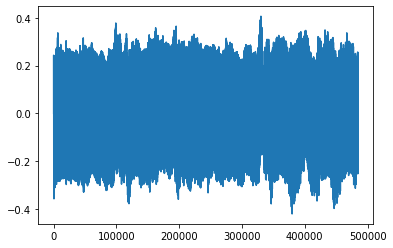

In [56]:
fuzzOut = fuzz(input1,0.25,treshold=0.005)
fuzzFiltered = highpass_filter(fuzzOut,sr1)
plt.plot(fuzzFiltered)
plt.show()
ipd.Audio(fuzzFiltered,rate=sr1)

In [16]:
def distortion(inputAudio,treshold=0.25):
    audio = np.copy(inputAudio)
    for sample in np.nditer(audio, op_flags = ['readwrite']):
        if sample >= treshold:
            sample[...] = treshold
        elif sample <= -treshold:
            sample[...] = -treshold
    return audio



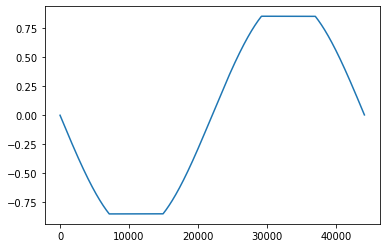

In [17]:
distortionSine = distortion(sine,treshold=0.85)
plt.plot(distortionSine)
plt.show()


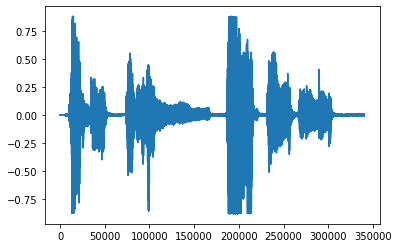

In [18]:
plt.plot(input3)
plt.show()
ipd.Audio(input3,rate=sr1)

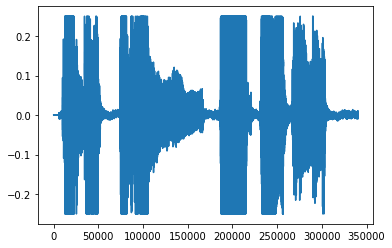

In [19]:
distOut = distortion(input3)
plt.plot(distOut)
plt.show()
ipd.Audio(distOut,rate=sr1)

In [20]:
def combFilter(inputAudio,sampleRate,delayInMs=78,decayFactor=0.45):
    audio = np.copy(inputAudio)
    length = audio.size
    delay = int(delayInMs * (sampleRate/1000))
    for i in range(0,length-delay):
        audio[i + delay] += audio[i]*decayFactor
    return audio
    

In [29]:
def allPassFilter(inputAudio,sampleRate):
    audio = np.copy(inputAudio)
    length = audio.size
    delay = int(89.27 * (sampleRate/1000))
    decayFactor = 0.131
    for i in range(0,length):
        if(i - delay >= 0):
            audio[i] += -decayFactor * audio[i - delay]
        if(i - delay >= 1):
            audio[i] += decayFactor * audio[i+20 - delay]
       
    return audio

In [24]:
def reverb(inputAudio,sampleRate,delayInMs=78.9,decayFactor=0.45,mixPercent=0.5):
    audio = np.copy(inputAudio)
    length = audio.size
    comb1 = combFilter(audio,sampleRate,delayInMs,decayFactor)   
    comb2 = combFilter(audio,sampleRate,delayInMs - 11.73,decayFactor - 0.1313)   
    comb3 = combFilter(audio,sampleRate,delayInMs + 19.31,decayFactor - 0.2743)   
    comb4 = combFilter(audio,sampleRate,delayInMs - 7.97 ,decayFactor - 0.3100)
    for i in range(0,length):
        audio[i] = comb1[i] + comb2[i] + comb3[i] + comb4[i]
        audio[i] = (1 - mixPercent) * inputAudio[i] + (mixPercent * audio[i])
    return allPassFilter(allPassFilter(audio,sampleRate),sampleRate)
        


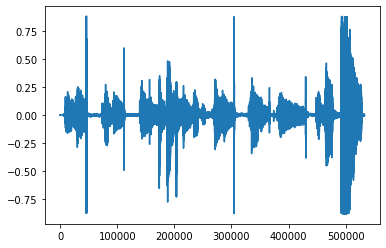

In [22]:
plt.plot(input2)
plt.show()
ipd.Audio(input2,rate=sr2)

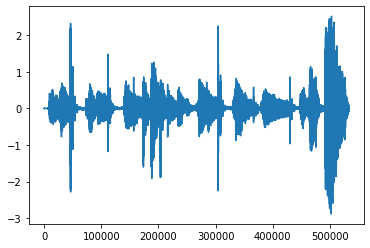

In [30]:
reverbOut = reverb(input2,sr2)
plt.plot(reverbOut)
plt.show()
ipd.Audio(reverbOut,rate=sr2)
